In [1]:
import os
import json
from pprint import pprint
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

# List to hold the data from all JSON files
all_json_data = []

# Get the current directory
current_directory = os.getcwd()

def flatten_results(results):
    flattened_results = []
    for key,val in results.items():
        for i,v in enumerate(val):
            flattened_results.append({
                'index':i,
                'benchmark':key,
                'prompt':v[0],
                'success':v[1],
                'captured':repr(v[2][:-1]),
                'code':v[2][-1]
            })
    return flattened_results

# Loop through all files in the current directory
for filename in os.listdir(current_directory):
    if filename.endswith('.json'):
        file_path = os.path.join(current_directory, filename)
        
        # Open and read the JSON file
        with open(file_path, 'r') as file:
            try:
                json_data = json.load(file)

                label = ''.join(filename.split('.')[:-1]).split('_')[-1]

                for key,val in json_data.items():                

                    status = {
                        'model':label
                    }

                    if val['status'] != 'success':
                        continue

                    flattened_results = flatten_results(val['results'])
                    for v in flattened_results:
                        v.update(status)
                        
                    all_json_data+=flattened_results
            except json.JSONDecodeError as e:
                print(f"Error reading {filename}: {e}")

# Now, all_json_data contains the contents of all JSON files

df = pd.DataFrame(all_json_data)

In [2]:
result = df.groupby(['model'])['success'].agg(['mean', 'std'])

# Renaming columns for clarity
result.rename(columns={'mean': 'Average Success Rate', 'std': 'Standard Deviation'}, inplace=True)

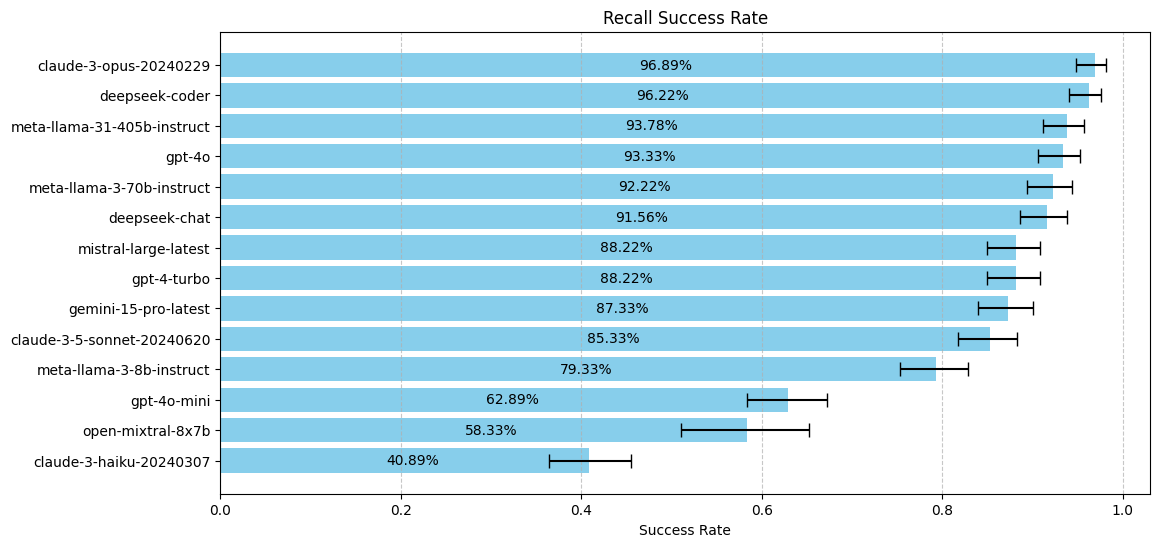

In [3]:
# Adding successes count
df['success_count'] = df['success'].astype(int)

# Grouping by benchmark and model and calculating success counts and total counts
grouped = df.groupby(['model']).agg(
    success_count=('success_count', 'sum'),
    total_count=('success_count', 'count')
)

# Applying the Wilson score confidence interval
grouped['success_rate'] = grouped['success_count'] / grouped['total_count']


# Applying the Wilson score confidence interval
grouped['lower'], grouped['upper'] = zip(*grouped.apply(
    lambda x: proportion_confint(x['success_count'], x['total_count'], method='wilson'), axis=1
))

from matplotlib import pyplot as plt

# Sorting the DataFrame by success_rate in descending order
grouped.sort_values('success_rate', ascending=True, inplace=True)

# Error bars (distance from mean success rate to lower and upper confidence limits)
grouped['error_lower'] = grouped['success_rate'] - grouped['lower']
grouped['error_upper'] = grouped['upper'] - grouped['success_rate']
errors = grouped[['error_lower', 'error_upper']].T.values

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_labels = grouped.index.map(lambda x: f"{x}")  # Combine benchmark and model for labels

bars = ax.barh(bar_labels, grouped['success_rate'], xerr=errors, color='skyblue', capsize=5)
ax.set_xlabel('Success Rate')
ax.set_title('Recall Success Rate')

# Adding percentage text at the end of bars
for bar in bars:
    width = bar.get_width()
    ax.text(width/2 - 0.02, bar.get_y() + bar.get_height()/2, f'{width:.2%}', va='center')

plt.grid(True, linestyle='--', which='both', axis='x', alpha=0.7)
plt.show()

In [4]:
grouped['total_count']

model
claude-3-haiku-20240307        450
open-mixtral-8x7b              180
gpt-4o-mini                    450
meta-llama-3-8b-instruct       450
claude-3-5-sonnet-20240620     450
gemini-15-pro-latest           450
gpt-4-turbo                    450
mistral-large-latest           450
deepseek-chat                  450
meta-llama-3-70b-instruct      450
gpt-4o                         450
meta-llama-31-405b-instruct    450
deepseek-coder                 450
claude-3-opus-20240229         450
Name: total_count, dtype: int64